# PCA workshop

This workshop has been presented on September 19th, 2019, during the Python User Group meeting at OUHSC/OMRF.

Introduction
---

In this tutorial, you will learn how to compute and plot Principal Components from scratch using Python, as well as to use the scikit-learn package to do the same.


The dataset that I provided is a handful of 16S rRNA sequencing samples that were deposited in the MGnify database: https://www.ebi.ac.uk/metagenomics/ . The "counts.tsv" file represents counts of selected microbes per sample. A similar procedure is applicable in the case when the data is gene counts per sample.

The goal of this analysis is to see which samples are similar to each other with respect to the microbiome, as is represented by a compressed data.

---

Instructions
---

1. Go to https://jupyter.org/try and click on "Try JupyterLab".
1. Open new terminal:
    - Locate the "+" sign
    - Chose "Other" > "Terminal"
1. Clone the repo:
`git clone https://gitlab.com/aperz/my-pca---workshop.git`
1. Using the folder icon to the left, navigate into the home directory and into the `my-pca---workshop` repository
1. You should be able to see the files listed to the left of the screen


Jupyter Notebook essentials
---

| Shortcut  | Action |
|-----------|--------|
|Enter      | Enter cell for editing |
|ESC        | Exit cell |
|Shift+Enter| Execute code in cell |
|b          | Insert a new cell below |
|c          | Copy cell |
|p          | Paste cell |
|x          | Delete cell |


To get details about a Python function or an object, type, e.g. `np.sum??`.

Libraries used in this workshop:
1. numpy - an array library
1. pandas - a data frame library (arrays plus)
1. seaborn - plotting
1. matplotlib - plotting
1. scikit-learn - an ML library

---

# PART 1: Loading and preprocessing the data

In [1]:
# Jupyter Notebook settings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the microbiome dataset
import pandas as pd
import numpy as np

counts_filepath = "counts.tsv"
metadata_filepath = "metadata.tsv"

A = pd.read_csv(counts_filepath, sep='\t', index_col=0)
A_rownames = A.index
A_colnames = A.columns

metadata = pd.read_csv(metadata_filepath, sep='\t', index_col=0)

In [208]:
# Here is an alternative very small dataset
A = np.array([[-1, 1, 2, 2],
              [-2, 3, 1, 0],
              [ 4, 0, 3,-1]])
A_rownames = ["sample1", "sample2", "sample3"]
A_colnames = ["microbe1", "microbe2", "microbe3", "microbe4"]

metadata = pd.DataFrame({"sample":A_rownames, "biome":["biome1", "biome2", "biome3"]})

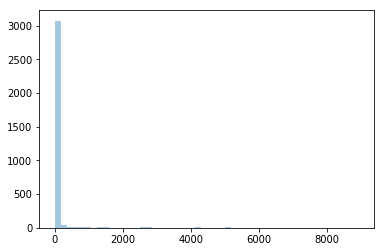

In [4]:
# Explore data
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(A.values.ravel(), kde=False)
plt.show()

In [5]:
# Preprocess the data

#Log-transform
A = A.applymap(lambda x: np.log(x+1))

# Normalize
A = A.apply(lambda x: x-np.mean(x)/np.std(x), axis=1)

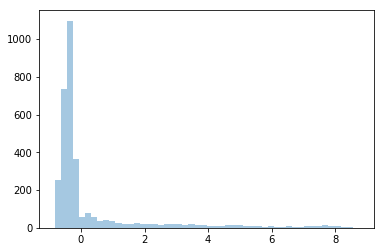

In [6]:
# Explore preprocessed data
sns.distplot(A.values.ravel(), kde=False)
plt.show()

In [7]:
total_variance = A.apply(np.var).sum()
explained_variance = A.apply(lambda x: np.var(x)/total_variance)

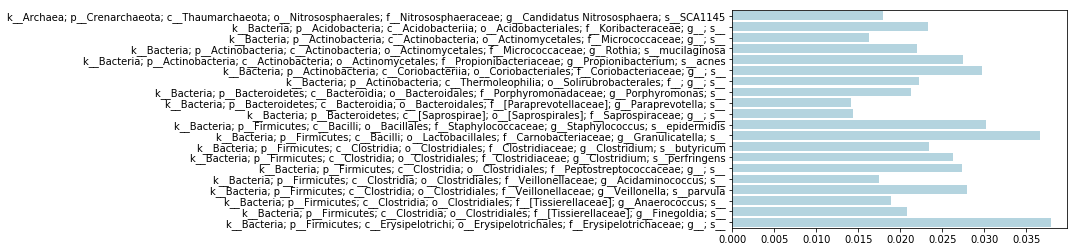

In [8]:
data = explained_variance
# Explore preprocessed data: plot explained variance
sns.barplot(
    x = data[:20],
    y = data.index[:20],
    color = "lightblue"
    )
plt.show()

In [9]:
A = A.values

# PART 2: Principal Components Analysis

In [10]:
# calculate the mean of each column (feature)
M = np.mean(A.T, axis=1)
# center columns by subtracting column means
C = A - M
# calculate covariance matrix of centered matrix
V = np.cov(C.T)

# eigendecomposition of covariance matrix
# values are the explained variance for each component
values, vectors = np.linalg.eig(V) #this may take a while to compute
explained_variance_ratio = [i/sum(values) for i in values]

# project data onto the component-space
P = vectors.T.dot(C.T)
P = P.T

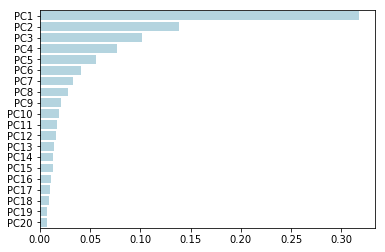

In [11]:
# Prepare data for plotting
data = pd.Series(
    explained_variance_ratio, 
    index = ["PC"+str(i+1) for i in range(len(explained_variance_ratio))]
    )
# Explore preprocessed data
sns.barplot(
    x = data[:20], 
    y = data.index[:20], color="lightblue"
    )
plt.show()

In [12]:
# select eigenvectors with the largest explained variance
explained_variance_reduced = explained_variance_ratio[:2]
components_reduced = P[:,:2]
print(explained_variance_reduced)
print(components_reduced[:5,:])

[0.3171259247345152, 0.13878265968654407]
[[-3.50496423 -1.11643394]
 [-4.89096476 -1.43276274]
 [-5.86417764  1.13068537]
 [-4.04223274  4.80629494]
 [-3.40748744  6.28200165]]


# PART 3: Plotting

In [13]:


# Prepare the data to be plotted
data = pd.DataFrame(
            {
            "PC1":components_reduced[:,0],
            "PC2":components_reduced[:,1],
            "biome":metadata['biome'],
            },
        index = A_rownames)
print(data.head())

                 PC1       PC2  biome
sample_id                            
ERS1058158 -3.504964 -1.116434  Fecal
ERS1058223 -4.890965 -1.432763  Fecal
ERS1058252 -5.864178  1.130685  Fecal
ERS1059262 -4.042233  4.806295  Fecal
ERS1059279 -3.407487  6.282002  Fecal


In [14]:
data.PC1 = data.PC1.apply(lambda x: x-np.mean(data.PC1)/np.std(data.PC1))
data.PC2 = data.PC2.apply(lambda x: x-np.mean(data.PC2)/np.std(data.PC2))

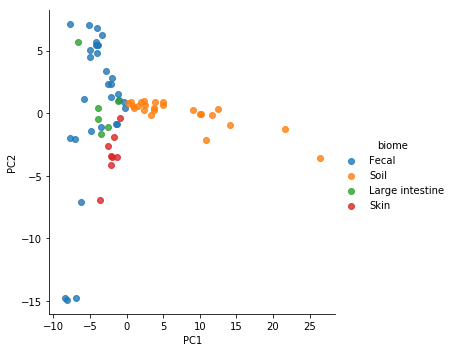

In [15]:
# Plot using the seaborn library
sns.lmplot(data=data, x = "PC1", y="PC2", hue="biome", fit_reg=False)
plt.show()

# PART 4: PCA using sklearn

In [16]:
# Principal Component Analysis
import numpy as np
from sklearn.decomposition import PCA
# create the PCA instance
pca = PCA(2)
# fit on data
pca.fit(A)
# apply the transformation to the data
B = pca.transform(A)
print(pca.explained_variance_ratio_)
print(B[:5,])

[0.31712592 0.13878266]
[[-3.50496423  1.11643394]
 [-4.89096476  1.43276274]
 [-5.86417764 -1.13068537]
 [-4.04223274 -4.80629494]
 [-3.40748744 -6.28200165]]


In [17]:
# Prepare the data to be plotted
data_sklearn = pd.DataFrame(
            {
            "PC1":B[:,0],
            "PC2":B[:,1],
            "biome":metadata['biome'],
            },
        index = A_rownames)
print(data_sklearn.head())

                 PC1       PC2  biome
sample_id                            
ERS1058158 -3.504964  1.116434  Fecal
ERS1058223 -4.890965  1.432763  Fecal
ERS1058252 -5.864178 -1.130685  Fecal
ERS1059262 -4.042233 -4.806295  Fecal
ERS1059279 -3.407487 -6.282002  Fecal


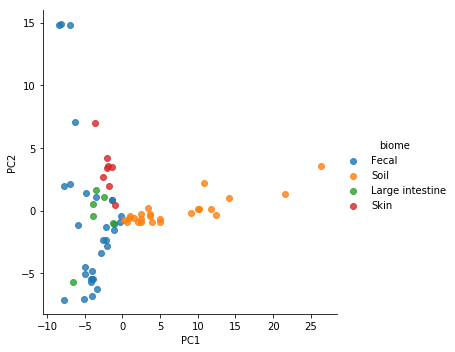

In [18]:
# Plot using the seaborn library
sns.lmplot(data=data_sklearn, x = "PC1", y="PC2", hue="biome", fit_reg=False)
plt.show()

# PART 5: Additional analyses

1. Plot **cumulative** explained variance for:
    1. the original variables;
    1. Principal Components.
    
1. Find which variables contribute to the first PC.
(https://chrisalbon.com/machine_learning/feature_engineering/feature_extraction_with_pca/)

## Further information on PCA
https://stats.stackexchange.com/a/140579/142668
https://medium.com/data-design/how-to-not-be-dumb-at-applying-principal-component-analysis-pca-6c14de5b3c9d

## Sources
https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

## Contact
Author: Aleksandra Perz (OMRF/OUHSC) perz.aleksandra@gmail.com